In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#from Md import Md, normalize
import os
import pandas as pd
import pickle
import glob
from PIL import Image
import math
from skimage.transform import resize

In [14]:
!pip install face_alignment

In [15]:
import face_alignment
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import collections
# Optionally set detector and some additional detector parameters
face_detector = 'sfd'
face_detector_kwargs = {
    "filter_threshold" : 0.8
}
#you can change device to 'gpu'

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cuda', flip_input=True,
                                  face_detector=face_detector, face_detector_kwargs=face_detector_kwargs)


In [16]:
def bulat_al(imHead,fa):#second check
    try : 
            preds = fa.get_landmarks(imHead)[-1]#predict
          # 2D-Plot
            pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
            pred_types = {
                    'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                    'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                    }
            centers=[]
            Avr_eye=24 #24 represents average eye length for adults, we use this to set the scale

            for pred_type in pred_types.values():
                x=preds[pred_type.slice, 0]
                y=preds[pred_type.slice, 1]
                centroid = (sum(x) / len(x), sum(y) / len(y)) #get centroid
                centers.append(centroid) #append
            dist = math.hypot(centers[0][0]-centers[1][0],centers[0][1]-centers[1][1]) #distance on image
            dist_reel= np.divide(dist*24,x.max()-x.min() )#real distance
            if (77 >dist_reel>51):  #normal distance between pupils is between 51 and 77
                centers = [(int(element[0]), int(element[1])) for element in centers]
                imEye_r=imHead[centers[0][0]-7:centers[0][0]+7,centers[0][1]-7:centers[0][1]+7,:]
                imEye_l=imHead[centers[1][0]-7:centers[1][0]+7,centers[1][1]-7:centers[1][1]+7,:]
                fl= imEye_l.flatten()
                fr= imEye_r.flatten()
                imEye_r = cv.resize(imEye_r,(60,36)) 
                imEye_l = cv.resize(imEye_l,(60,36)) 
            else :
                blank_image = np.zeros((36,60,3), np.uint8)
                imEye_l = blank_image
                imEye_r = blank_image
    except : 
            blank_image = np.zeros((36,60,3), np.uint8)
            imEye_l = blank_image
            imEye_r = blank_image
    return imEye_l,imEye_r

In [17]:
# extract head image
def extract_head(img, xi,yi,xg,yg):
    x,y= np.shape(img)[0:2] # height and width of image
    
    # point entre les yeux
    xg=int(xg*y)
    yg=int(yg*x)
    
    #point sommet gauche
    xi=int(y*xi)
    yi=int(x*yi)
    
    head=img[yi:yi+(yg-yi)*2,xi:xi+(xg-xi)*2]
    return head

def extract_target(img,xtr,ytr):
    x,y = np.shape(img)[0:2] 
    target=[int(ytr*x),int(xtr*y)]  # correspondent aux coordonnées x, sur l'image python
    return target

In [32]:
num=['45','46','48','49']
def load_images_from_folder(folder,i):
    images = []
    img_path = []
    img_name = []
    
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC))  # resize image
            #img_path.append(folder +"/" +filename)
            img_path.append('train/000000'+ num[i]+"/" +filename) 
            img_name.append('000000'+ num[i]+"/" +filename)            
            
    return images, img_path, img_name

In [33]:
path_base_data="/content/gdrive/MyDrive/dataset" # database path
path_annotation="/content/gdrive/MyDrive/dataset/train_annotations.txt" #annotation path
directories=[x[0] for x in os.walk(path_base_data)] # list of different directories in database

In [34]:
print(directories)

['/content/gdrive/MyDrive/dataset', '/content/gdrive/MyDrive/dataset/00000045', '/content/gdrive/MyDrive/dataset/00000046', '/content/gdrive/MyDrive/dataset/00000048', '/content/gdrive/MyDrive/dataset/00000049']


In [35]:
# base de donnée de test pour gaze estimation --> determiner alors gx,gy,gz, 
imgs=[]
imgs_heads=[]
imgs_right_eye=[] 
imgs_left_eye=[] 
imgs_target=[]
imgs_name=[]
imgs_path=[]


In [36]:
# for all images
def get_images(directories):
    imgs = []
    imgs_path = []
    imgs_name = []
    for i in range (len(directories)-1):         
        img, img_path, img_name = load_images_from_folder(directories[i+1],i)
       
        imgs.append(img)  
        imgs_path.append(img_path)
        imgs_name.append(img_name)
                        
    return imgs, imgs_path, imgs_name

imgs, imgs_path, imgs_name = get_images(directories) 
# it takes 1.35 min to execute

(1, 4000, 224, 224, 3)


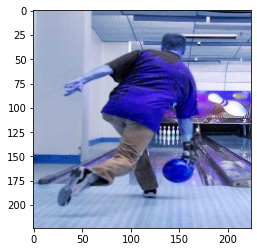

In [42]:
imgs = np.reshape(imgs,(1,4000,224,224,3))
print(np.shape(imgs))
imgs_path = np.reshape(imgs_path,(1,4000))
plt.imshow(imgs[0][0])

In [62]:
imgs_name = np.reshape(imgs_name,(1,4000))

In [43]:
# get information from the txt file
def get_annotation(path_annotation):
    with open(path_annotation, 'r') as f:
        annotations = [[num for num in line.split(',')] for line in f]
    f.close()
    annotations = np.array(annotations)
    return annotations

annotations = get_annotation(path_annotation)

In [44]:
def part_annotation(imgs, imgs_path, annotations):
  part_annot=[]
  for i in range (4000):
    l = 0
    for k in annotations[:,0]:           
      if k==imgs_path[0][i]:
        part_annot.append(annotations[l])
      l=l+1
  return part_annot

In [45]:
part_annot= part_annotation(imgs, imgs_path, annotations)
# it takes  11 min to execute

In [46]:
print(np.shape(part_annot))

(4000, 12)


In [49]:
# build the head data, get target position , extract left and right eye 
def create_data(imgs, imgs_path, part_annot):
    imgs_heads=[]
    imgs_target=[]
    imgs_right_eye=[] 
    imgs_left_eye=[]

    for i in range (4000):  
        
        target=np.zeros((np.shape(imgs)[0],2))
       
        img= extract_head(imgs[0][i],float(part_annot[i][2]),float(part_annot[i][3]),float(part_annot[i][6]),float(part_annot[i][7]))           
        target=extract_target(imgs[0][i],float(part_annot[i][8]),float(part_annot[i][9]))   
        # eye extraction
        imEye_l,imEye_r= bulat_al(img,fa)
        
        #imgs_heads.append(cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC))  #vecteur ligne
        imgs_heads.append(img)
        imgs_target.append(target) #vecteur ligne
        imgs_right_eye.append(imEye_r)
        imgs_left_eye.append(imEye_l)     
        
    return imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye
    

In [50]:
# gaze follow data
imgs_heads, imgs_target, imgs_right_eye, imgs_left_eye = create_data(imgs, imgs_path, part_annot)
# it takes  15 min to execute

/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:144: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


In [63]:
print(np.shape(imgs_heads))
print(np.shape(imgs_target))
print(np.shape(imgs))
print(np.shape(imgs_name))
print(np.shape(imgs_right_eye))

(4000,)
(4000, 2)
(1, 4000, 224, 224, 3)
(1, 4000)
(4000, 36, 60, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


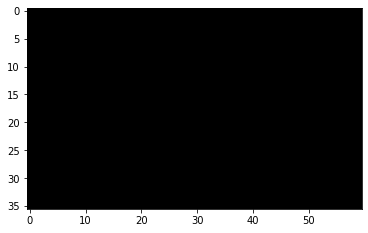

In [56]:
plt.imshow(imgs_right_eye[800])

In [57]:
# create the pickle files
with open('imgs_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs, f)

with open('imgs_path_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_path, f)

with open('imgs_heads_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_heads, f)

with open('imgs_target_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_target, f)

with open('imgs_right_eye_gaze_follow.pkl', 'wb') as f:
    pickle.dump( imgs_right_eye, f)

with open('imgs_left_eye_gaze_follow.pkl', 'wb') as f:
    pickle.dump( imgs_left_eye, f)


In [64]:
print(imgs_name[0][3999])

00000049/00049970.jpg


In [67]:
# save images to input file for depth estimation
path_depth_estimation_input='/content/gdrive/MyDrive/Dual_Attention_Guided_Gaze/depth_estimation/input/'
for i in range (4000): 
    ig = cv.imread("/content/gdrive/MyDrive/dataset/" + imgs_name[0][i])   
    
    cv.imwrite(path_depth_estimation_input + str(i)+".jpg", ig)

# it takes  1.45 min to execute

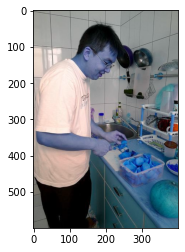

In [ ]:
# build the heatmaps
def DAM(depth_maps, FOV_maps,imgs_heads, gz):
    for i in range (np.size(depth_maps)):    
        heat_maps=Md(depth_maps[i], imgs_heads[i], gz[i]) # on doit multiplier par le module FOV
    
    return heat_maps
